In [9]:
%%writefile e.cpp
#include<iostream>
#include<cmath>
#include "vector.h"

const double G = 1.0;
const int N = 3;

const double xi = 0.1786178958448091;
const double lambda = -0.2123418310626054;
const double chi = -0.06626458266981849;
const double Um2lambdau2 = (1 - 2 * lambda) / 2;
const double Um2chiplusxi = 1 - 2 * (chi + xi);

class body;
class collider;

//------------------------------------------//

class body {
private:

public:
	vector3D r, V, F;
	double m, R;
	void start(double x0, double y0, double z0,
		double Vx0, double Vy0, double Vz0, double m, double R0);
	void SumForce(vector3D dF);
	void EraseForce(void) { F.load(0, 0, 0); };
	void Mover(double dt, double coeff);
	void Movev(double dt, double coeff);
	double Getx(void) { return r.x(); }; //inline
	double Gety(void) { return r.y(); };//inline
	double Getz(void) { return r.z(); };//inline
	friend class collider;
};

class collider {
private:

public:
	void CalculateEveryForce(body* bodies);
	void CalculateForceBetween(body& planet1, body& planet2);
};
//-----------------------------------------------//
void body::start(double x0, double y0, double z0, double Vx0,
	double Vy0, double Vz0, double m0, double R0) {
	r.load(x0, y0, z0);
	V.load(Vx0, Vy0, Vz0);
	m = m0;
	R = R0;
}

void body::SumForce(vector3D dF) {
	F += dF;
}

void body::Mover(double dt, double coeff) {
	r += V * coeff * dt;
}

void body::Movev(double dt, double coeff) {
	V += (F / m) * coeff * dt;
}

void collider::CalculateEveryForce(body* planet) {
	int i, j;
	for (i = 0; i < N; i++) {
		planet[i].EraseForce();
	}
	for (i = 0; i < N; i++) {
		for (j = 0; j < i; j++) {
			CalculateForceBetween(planet[i], planet[j]);
		}
	}
}

void collider::CalculateForceBetween(body& planet1, body& planet2) {
	double m1 = planet1.m;
	double m2 = planet2.m;
	vector3D r21 = planet2.r - planet1.r;
	double r2 = r21.norm2();
	double aux = G * m2 * m1 * std::pow(r2, -1.5);
	vector3D F1 = aux * r21;
	planet1.SumForce(F1);
	planet2.SumForce(F1 * (-1));
}

//--------------------------------------------//
int main() {
	//Body 0 = Sun, Body 1 = Jupiter, Body 2 = Trojan
	double dt = 0.1;
	double r = 1000.0; //Distance from Jupiter to the sun
	//Masses and total mass
	double m0 = 1047.0, m1 = 1.0, m2 = 0.005;
	double M = m0 + m1 + m2;
	//Origin centered system
	double x0 = -r * (m2 * cos(60 * M_PI / 180) + m1) / M;
	double y0 = -r * m2 * sin(60 * M_PI / 180) / M;
	double x1 = r * (m0 + m2 * (1 - cos((60 * M_PI / 180)))) / M;
	double y1 = -r * m2 * sin(60 * M_PI / 180) / M;
	double x2 = r * (m0 * (cos(60 * M_PI / 180)) + m1 * (cos(60 * M_PI / 180) - 1)) / M;
	double y2 = r * sin(60 * M_PI / 180) * (m0 + m1) / M;

	//angular velocity and time frame
	double omega = sqrt(G * M / (pow(r, 3)));
	double T = 2 * M_PI / omega;
	double Ttotal = 50 * T;
	//velocities in new system
	double r0 = sqrt(x0 * x0 + y0 * y0);
	double r1 = sqrt(x1 * x1 + y1 * y1);
	double v0 = omega * r0;
	double v1 = omega * r1;
	double angles = fabs(atan(y0 / x0));
	double anglej = fabs(atan(y1 / x1));
	//initial parameters for velocities
	double v0x = v0 * sin(angles);
	double v0y = -v0 * cos(angles);
	double v1x = v1 * sin(anglej);
	double v1y = v1 * cos(anglej);
	double v2x = -(v1 + 0.005) * sin(60 * M_PI / 180);
	double v2y = (v1 + 0.005) * cos(60 * M_PI / 180);

	collider newton;
	body bodies[N];

	//x0, y0, Vx0, Vy0, m0, R0
	bodies[0].start(x0, y0, 0, v0x, v0y, 0, m0, 1.0);
	bodies[1].start(x1, y1, 0, v1x, v1y, 0, m1, 0.5);
	bodies[2].start(x2, y2, 0, v2x, v2y, 0, m2, 0.01);

	for (double t = 0; t < Ttotal; t += dt) {

		double angle = omega * t;

		double rotsun[2];
		double rotjup[2];
		double rottroy[2];

		rotsun[0] = bodies[0].Getx() * std::cos(-angle) - bodies[0].Gety() * std::sin(-angle);
		rotsun[1] = bodies[0].Getx() * std::sin(-angle) + bodies[0].Gety() * std::cos(-angle);

		rotjup[0] = bodies[1].Getx() * std::cos(-angle) - bodies[1].Gety() * std::sin(-angle);
		rotjup[1] = bodies[1].Getx() * std::sin(-angle) + bodies[1].Gety() * std::cos(-angle);

		rottroy[0] = bodies[2].Getx() * std::cos(-angle) - bodies[2].Gety() * std::sin(-angle);
		rottroy[1] = bodies[2].Getx() * std::sin(-angle) + bodies[2].Gety() * std::cos(-angle);


		/*std::cout << rotsun[0] << " " << rotsun[1] << " "
			<< rotjup[0] << " " << rotjup[1] << " "
			<< rottroy[0] << " " << rottroy[1] << " "
			<< std::endl;
		*/

		std::cout << t << " " << rottroy[0] << std::endl;

		for (int i = 0; i < N; i++) {
			bodies[i].Mover(dt, xi);
		}
		newton.CalculateEveryForce(bodies);

		for (int i = 0; i < N; i++) {
			bodies[i].Movev(dt, Um2lambdau2);
		}

		for (int i = 0; i < N; i++) {
			bodies[i].Mover(dt, chi);
		}

		newton.CalculateEveryForce(bodies);

		for (int i = 0; i < N; i++) {
			bodies[i].Movev(dt, lambda);
		}

		for (int i = 0; i < N; i++) {
			bodies[i].Mover(dt, Um2chiplusxi);
		}

		newton.CalculateEveryForce(bodies);

		for (int i = 0; i < N; i++) {
			bodies[i].Movev(dt, lambda);
		}

		for (int i = 0; i < N; i++) {
			bodies[i].Mover(dt, chi);
		}

		newton.CalculateEveryForce(bodies);

		for (int i = 0; i < N; i++) {
			bodies[i].Movev(dt, Um2lambdau2);
		}

		for (int i = 0; i < N; i++) {
			bodies[i].Mover(dt, xi);
		}
	}

	return 0;
}

Overwriting e.cpp


In [10]:
%%shell
g++ e.cpp
./a.out > e.dat

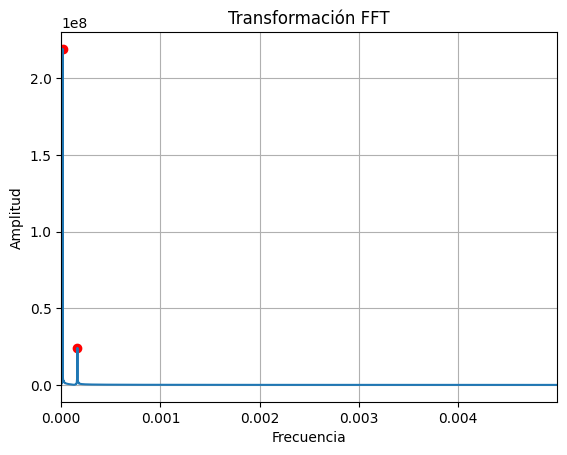

T: [ 6137.596 76719.95 ]


In [15]:
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt


file_path = 'e.dat'
datos = pd.read_csv(file_path, sep=' ', header=None, names=['Tiempo', 'Posición'])

frecuencia_muestreo = 1 / 0.1
num_puntos = datos.shape[0]

array_posicion = datos['Posición'].to_numpy()
array_posicion_centrado = array_posicion - np.mean(array_posicion)
espectro_fft_centrado = fft(array_posicion_centrado)
espectro_fft_centrado = np.abs(espectro_fft_centrado[:num_puntos//2])

frecuencias_xf = fftfreq(num_puntos, 1 / frecuencia_muestreo)[:num_puntos//2]
picos, _ = find_peaks(espectro_fft_centrado, height=0)
indices_picos_principales = np.argsort(espectro_fft_centrado[picos])[-2:]
frecuencias_picos_principales_tiempo_real = frecuencias_xf[picos][indices_picos_principales]

plt.plot(frecuencias_xf, espectro_fft_centrado)
plt.scatter(frecuencias_picos_principales_tiempo_real, espectro_fft_centrado[picos][indices_picos_principales], color='red', label=" ")
plt.title("Transformación FFT")
plt.xlabel("Frecuencia")
plt.ylabel("Amplitud")
plt.grid(True)

plt.xlim(0, max(frecuencias_xf)/1000)
plt.show()
print("T:", 1/frecuencias_picos_principales_tiempo_real)